In [58]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [60]:
# Load the dataset
data_path = 'data/MSFT.csv'
df = pd.read_csv(data_path)

# Parse the 'Date' column and add it as a feature
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'] = df['Date'].map(lambda x: x.toordinal())  # Convert Date to numerical format

# Normalize all features (including the targets)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define a function to create sequences for features and targets
def create_sequences_multivariate(data, lookback):
    feature_sequences = []
    target_sequences = []
    for i in range(lookback, len(data)):
        feature_sequences.append(data[i - lookback:i, :])  # Feature sequences
        target_sequences.append(data[i, :])  # Predict the next step for all columns
    return np.array(feature_sequences), np.array(target_sequences)

# Set lookback window size
lookback = 75

# Create sequences for features and targets
X, y = create_sequences_multivariate(scaled_data, lookback)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print data shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (6432, 75, 7), y_train shape: (6432, 7)
X_val shape: (1378, 75, 7), y_val shape: (1378, 7)
X_test shape: (1379, 75, 7), y_test shape: (1379, 7)


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam

# Define a function to build the Bidirectional LSTM model
def build_bi_lstm_model(input_shape, output_dim, units=64, learning_rate=0.001):
    """
    Builds a Bidirectional LSTM model.
    
    Parameters:
    - input_shape: Shape of the input data (time_steps, features)
    - output_dim: Number of output columns (target variables)
    - units: Number of units in the LSTM layer
    - learning_rate: Learning rate for the optimizer
    
    Returns:
    - model: Compiled Keras model
    """
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(units, activation='tanh', return_sequences=False)),
        Dense(output_dim)  # Predict all columns simultaneously
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
output_dim = X_train.shape[2]  # Number of output columns
bi_lstm_model = build_bi_lstm_model(input_shape=input_shape, output_dim=output_dim)

# Display model summary
bi_lstm_model.summary()

# Train the model
history_bi_lstm = bi_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,767 (147.53 KB)

 Trainable params: 37,767 (147.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 2.9920e-04 - val_mse: 2.9920e-04
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1431e-04 - mse: 2.1431e-04 - val_loss: 1.7085e-04 - val_mse: 1.7085e-04
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9387e-04 - mse: 1.9387e-04 - val_loss: 2.0188e-04 - val_mse: 2.0188e-04
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4972e-04 - mse: 1.4972e-04 - val_loss: 1.2848e-04 - val_mse: 1.2848e-04
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6500e-04 - mse: 1.6500e-04 - val_loss: 1.9580e-04 - val_mse: 1.9580e-04
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5878e-04 - mse: 1.5878e-04 - val_loss: 1.3999e-04 - val_mse: 1.3999e-04
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7387e-04 - mse: 1.7387e-04 - val_loss: 1.2532e-04 - val_mse: 1.2532e-04
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8738e-04

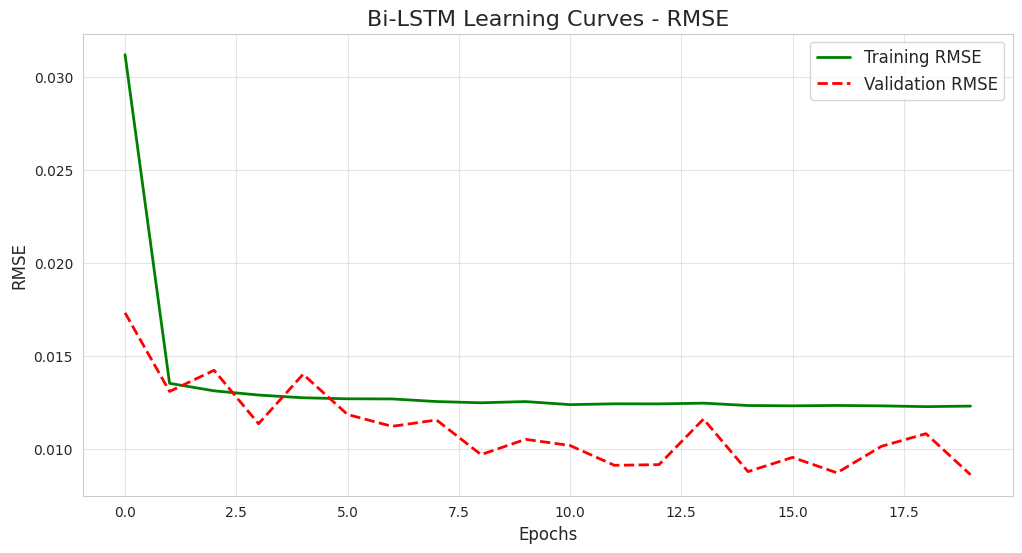

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a function to calculate RMSE and plot learning curves for it
def plot_rmse_learning_curves(history, title='Learning Curves - RMSE', figsize=(12, 6)):
    """
    Plots the RMSE learning curves for training and validation.
    
    Parameters:
    - history: Training history object from the Keras model
    - title: Title of the plot
    - figsize: Figure size
    """
    # Calculate RMSE from MSE
    train_rmse = np.sqrt(history.history['mse'])
    val_rmse = np.sqrt(history.history['val_mse'])

    plt.figure(figsize=figsize)
    sns.lineplot(data=train_rmse, label='Training RMSE', linewidth=2, color='green')
    sns.lineplot(data=val_rmse, label='Validation RMSE', linewidth=2, linestyle="--", color='red')
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

# Plot RMSE learning curves for the Bi-LSTM model
plot_rmse_learning_curves(history_bi_lstm, title='Bi-LSTM Learning Curves - RMSE')

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 75, 64)         │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │        33,607 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,015 (136.78 KB)

 Trainable params: 35,015 (136.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 3.8931e-04 - val_mse: 3.8931e-04
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 1.8260e-04 - mse: 1.8260e-04 - val_loss: 2.2620e-04 - val_mse: 2.2620e-04
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 1.5881e-04 - mse: 1.5881e-04 - val_loss: 2.3823e-04 - val_mse: 2.3823e-04
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 2.0354e-04 - mse: 2.0354e-04 - val_loss: 5.2515e-04 - val_mse: 5.2515e-04
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 1.8054e-04 - mse: 1.8054e-04 - val_loss: 2.4938e-04 - val_mse: 2.4938e-04
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 1.4717e-04 - mse: 1.4717e-04 - val_loss: 2.9077e-04 - val_mse: 2.9077e-04
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 1.4779e-04 - mse: 1.4779e-04 - val_loss: 1.9999e-04 - val_mse: 1.9999e-04
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - lo

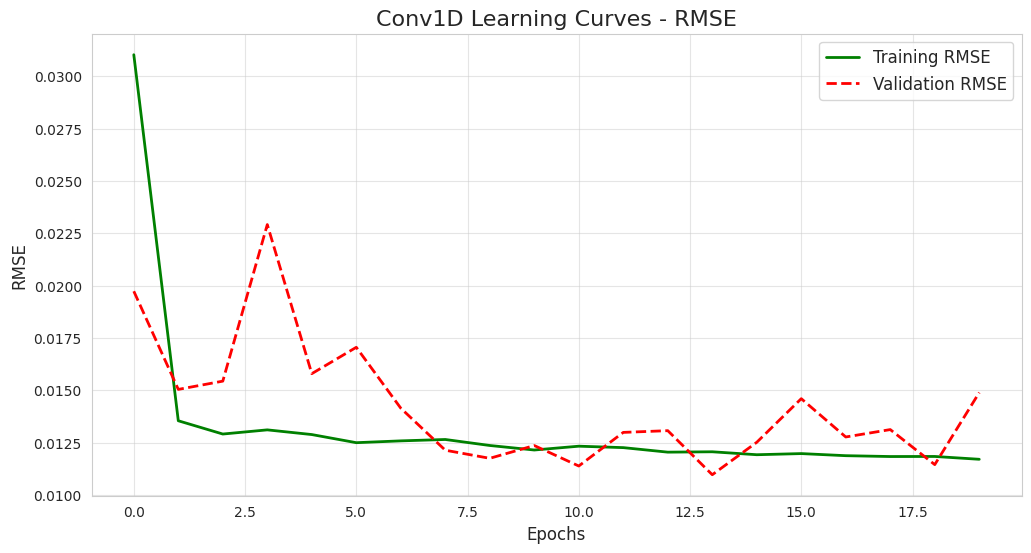

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a function to build the Conv1D model
def build_conv1d_model(input_shape, output_dim, filters=64, kernel_size=3, learning_rate=0.001):
    """
    Builds a Conv1D model.
    
    Parameters:
    - input_shape: Shape of the input data (time_steps, features)
    - output_dim: Number of output columns (target variables)
    - filters: Number of filters for Conv1D layer
    - kernel_size: Size of the convolution kernel
    - learning_rate: Learning rate for the optimizer
    
    Returns:
    - model: Compiled Keras model
    """
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
        Flatten(),
        Dense(output_dim)  # Predict all columns simultaneously
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    return model

# Build the Conv1D model
conv1d_model = build_conv1d_model(input_shape=input_shape, output_dim=output_dim)

# Display model summary
conv1d_model.summary()

# Train the Conv1D model
history_conv1d = conv1d_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Define a function to calculate RMSE and plot learning curves for Conv1D
def plot_rmse_learning_curves(history, title='Conv1D Learning Curves - RMSE', figsize=(12, 6)):
    """
    Plots the RMSE learning curves for training and validation.
    
    Parameters:
    - history: Training history object from the Keras model
    - title: Title of the plot
    - figsize: Figure size
    """
    # Calculate RMSE from MSE
    train_rmse = np.sqrt(history.history['mse'])
    val_rmse = np.sqrt(history.history['val_mse'])

    plt.figure(figsize=figsize)
    sns.lineplot(data=train_rmse, label='Training RMSE', linewidth=2, color='green')
    sns.lineplot(data=val_rmse, label='Validation RMSE', linewidth=2, linestyle="--", color='red')
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

# Plot RMSE learning curves for Conv1D
plot_rmse_learning_curves(history_conv1d, title='Conv1D Learning Curves - RMSE')

In [70]:
# Calculate the RMSE ratios for Conv1D and Bi-LSTM models
def calculate_rmse_ratios(model, X_test, y_test):
    """
    Calculate the RMSE ratio for each target attribute based on its mean.

    Parameters:
    - model: Trained Keras model
    - X_test: Test features
    - y_test: Test targets (scaled)

    Returns:
    - rmse_ratios: Dictionary with RMSE ratios for each attribute
    """
    predictions = model.predict(X_test)
    rmse_per_attribute = np.sqrt(np.mean((predictions - y_test) ** 2, axis=0))
    mean_per_attribute = np.mean(y_test, axis=0)
    rmse_ratios = rmse_per_attribute / mean_per_attribute
    return rmse_ratios

# Calculate RMSE ratios for both models
conv1d_rmse_ratios = calculate_rmse_ratios(conv1d_model, X_test, y_test)
bilstm_rmse_ratios = calculate_rmse_ratios(bi_lstm_model, X_test, y_test)

# Create a DataFrame to compare the RMSE ratios
comparison_df = pd.DataFrame({
    'Attribute': df.columns,
    'Conv1D RMSE Ratio': conv1d_rmse_ratios,
    'Bi-LSTM RMSE Ratio': bilstm_rmse_ratios
})

print("RMSE Ratio Comparison: Conv1D vs Bi-LSTM")
comparison_df.iloc

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE Ratio Comparison: Conv1D vs Bi-LSTM


,Attribute,Conv1D RMSE Ratio,Bi-LSTM RMSE Ratio
1,Low,0.098854,0.084053
2,Open,0.074678,0.092772
3,Volume,8.221344,0.482428
4,High,0.101170,0.097616
5,Close,0.047108,0.055858
6,Adjusted Close,0.211194,0.154763


In [71]:
from sklearn.metrics import mean_squared_error

# Evaluate Conv1D model on the test set
conv1d_test_predictions = conv1d_model.predict(X_test)
conv1d_rmse_test = np.sqrt(mean_squared_error(y_test, conv1d_test_predictions))
conv1d_mse_test = mean_squared_error(y_test, conv1d_test_predictions)

# Evaluate Bi-LSTM model on the test set
bilstm_test_predictions = bi_lstm_model.predict(X_test)
bilstm_rmse_test = np.sqrt(mean_squared_error(y_test, bilstm_test_predictions))
bilstm_mse_test = mean_squared_error(y_test, bilstm_test_predictions)

# Create a DataFrame to display the final test evaluation
test_evaluation_df = pd.DataFrame({
    'Model': ['Conv1D', 'Bi-LSTM'],
    'Test RMSE': [conv1d_rmse_test, bilstm_rmse_test],
    'Test MSE': [conv1d_mse_test, bilstm_mse_test]
})

test_evaluation_df


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Model,Test RMSE,Test MSE
0,Conv1D,0.097911,0.009587
1,Bi-LSTM,0.046009,0.002117
